<div>
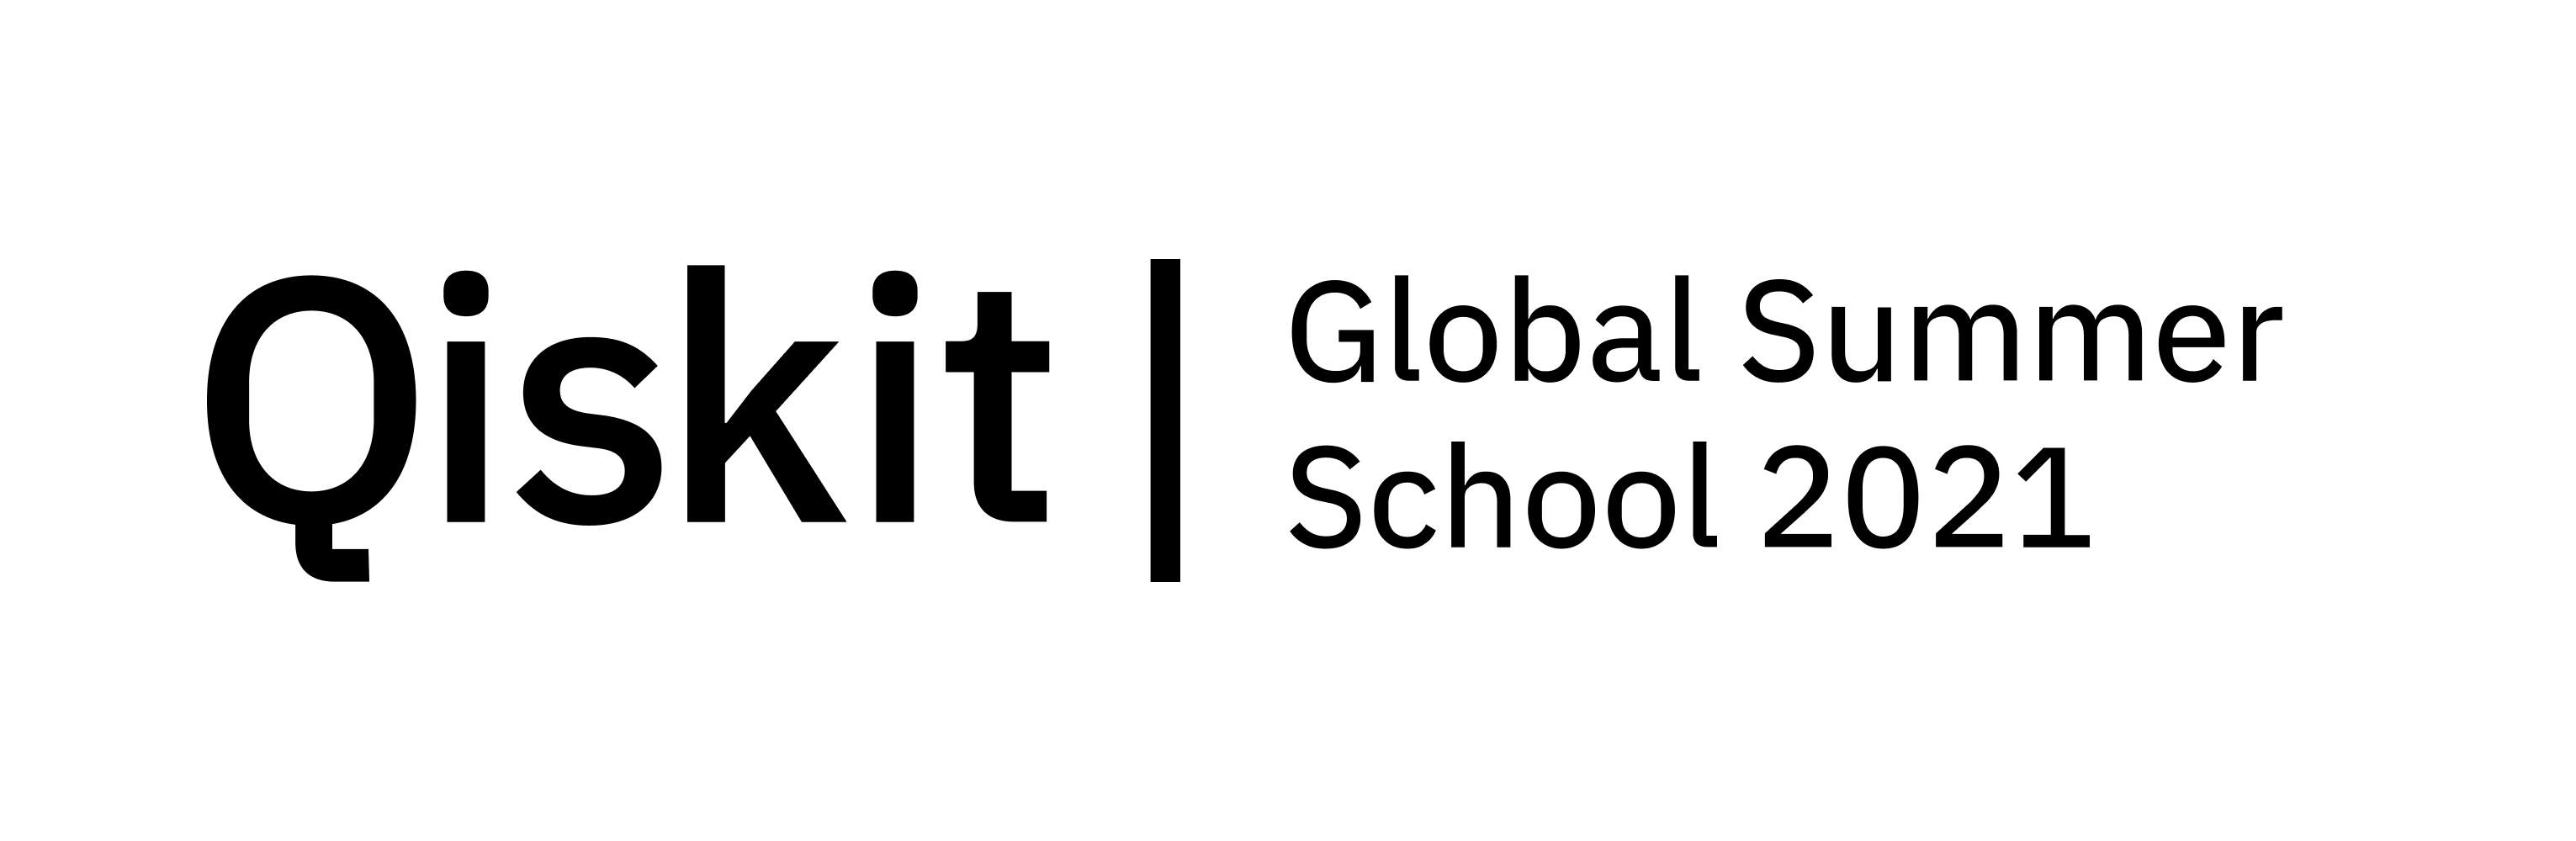
</div>

このLabでは、機械学習で使われる一般的なパラメーター化された量子回路にノイズが与える影響について、量子プロセス・トモグラフィーを使って学びます。

<div class="alert alert-danger" role="alert">
Gradingのために、全ての<b><i>execute</i></b>関数でのシミュレーターの引数について(<i>noise_model=noise_thermal, seed_simulator=3145, seed_transpiler=3145, shots=8192</i>)を指定してください。
    
</div>

In [ ]:
# 一般的なツール
import numpy as np
import matplotlib.pyplot as plt

# Qiskit Circuit 関連機能
from qiskit import  execute,QuantumCircuit, QuantumRegister, ClassicalRegister, Aer, transpile
import qiskit.quantum_info as qi

# トモグラフィーの機能
from qiskit.ignis.verification.tomography import process_tomography_circuits, ProcessTomographyFitter
from qiskit.ignis.mitigation.measurement import complete_meas_cal, CompleteMeasFitter

import warnings 
warnings.filterwarnings('ignore')

### Question 1
- この量子回路を作ってください。

<div>
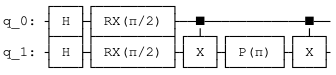
</div>

In [ ]:
target = QuantumCircuit(2)
target = # ここにコードを記入します
target_unitary = qi.Operator(target)

In [ ]:
from qc_grader import grade_lab5_ex1

# grade関数は測定なしの量子回路を期待していることに注意してください
grade_lab5_ex1(target)

# ショットノイズのみによる量子プロセス・トモグラフィー

ここでは、`qasm_simulator`で量子プロセス・トモグラフィー回路をシミュレートします。

### Question 2a

- Qiskitのプロセストモグラフィー（QPT）回路の機能を使って、量子プロセスト・モグラフィーを行う回路とQASMシミュレーター（ショットノイズのみ）のシミュレーションを作ってください。QPT回路の機能は、`seed_simulator=3145`, `seed_transpiler=3145`, `shots=8192`で実行してください。

- _ヒント：必要となる機能、<a href="https://qiskit.org/documentation/stubs/qiskit.ignis.verification.process_tomography_circuits.html">process_tomography_circuits</a>、は上記でインポートされています。完成すると、合計で144の回路が`execute`関数によって`qasm_simulator` に与えられるはずです。`len(qpt_circs)`を使って作成された回路の数を確認できます。_



In [ ]:
simulator = Aer.get_backend('qasm_simulator')
qpt_circs = # ここにコードを記入します
qpt_job = execute(qpt_circs,simulator,seed_simulator=3145,seed_transpiler=3145,shots=8192)
qpt_result = qpt_job.result()

### Question 2b

- プロセス・トモグラフィー・フィッターの最小二乗フィッティング法を使って、目標のユニタリー行列の忠実度(Fidelity)を決定してください。


- _ヒント: まず、上記の<a href="https://qiskit.org/documentation/stubs/qiskit.ignis.verification.ProcessTomographyFitter.html">ProcessTomographyFitter</a>関数を使ってQuestion 2aの結果を処理し、ProcessTomographyFitter.fit(method='....')を使って、測定されたユニタリー演算を効果的に記述した"Choi Matrix"を抽出します。ここからは、量子情報モジュールの<a href="https://qiskit.org/documentation/stubs/qiskit.quantum_info.average_gate_fidelity.html#qiskit.quantum_info.average_gate_fidelity">average_gate_fidelity</a>関数を使って、結果が達成した忠実度を抽出します。_


In [ ]:
# ここにコードを記入します

In [ ]:
from qc_grader import grade_lab5_ex2

# grade関数は浮動小数点を期待していることに注意してください
grade_lab5_ex2(fidelity)

# T1/T2ノイズモデルでの量子プロセス・トモグラフィー

一貫性を保つために、ゲートの持続時間とT1/T2時間を特徴付けるいくつかの値を設定しましょう：

In [ ]:
# 量子ビット０〜３のT1、T2の値
T1s = [15000, 19000, 22000, 14000]
T2s = [30000, 25000, 18000, 28000]

# 命令時間（ナノセカンド）
time_u1 = 0   # 仮想gate
time_u2 = 50  # (単一X90パルス)
time_u3 = 100 # (2個のX90パルス)
time_cx = 300
time_reset = 1000  # 1マイクロ秒
time_measure = 1000 # 1マイクロ秒

In [ ]:
from qiskit.providers.aer.noise import thermal_relaxation_error
from qiskit.providers.aer.noise import NoiseModel

### Question 3

- Qiskitの熱緩和エラーモデルを使って、上記で定義された量子ビット0〜3に対する値を使って、`u1`,`u2`,`u3`, `cx`, `measurement`,`reset` のエラーを定義し、熱ノイズモデルを構築してください。

- _ヒント：Qiskitチュートリアルの<a href="https://github.com/Qiskit/qiskit-tutorials/blob/master/tutorials/simulators/3_building_noise_models.ipynb">building noise models</a>が、特に、`u1`,`u2`,`u3`,`cx`, `reset`,`measurement` のエラーに対して役立ちます。（これら全てを含めてください。）_

In [ ]:
# QuantumErrorオブジェクト
errors_reset = [thermal_relaxation_error(t1, t2, time_reset)
                for t1, t2 in zip(T1s, T2s)]
errors_measure = [thermal_relaxation_error(t1, t2, time_measure)
                  for t1, t2 in zip(T1s, T2s)]
errors_u1  = [thermal_relaxation_error(t1, t2, time_u1)
              for t1, t2 in zip(T1s, T2s)]
errors_u2  = [thermal_relaxation_error(t1, t2, time_u2)
              for t1, t2 in zip(T1s, T2s)]
errors_u3  = [thermal_relaxation_error(t1, t2, time_u3)
              for t1, t2 in zip(T1s, T2s)]
errors_cx = [[thermal_relaxation_error(t1a, t2a, time_cx).expand(
             thermal_relaxation_error(t1b, t2b, time_cx))
              for t1a, t2a in zip(T1s, T2s)]
               for t1b, t2b in zip(T1s, T2s)]

# ノイズモデルにエラーを加えます
noise_thermal = NoiseModel()

# ここにコードを記入します

In [ ]:
from qc_grader import grade_lab5_ex3

# grade関数はNoiseModelを期待していることに注意してください
grade_lab5_ex3(noise_thermal)

### Question 4.

- ノイズモデルを使って、QPTの忠実度を出してください。ただし、エラー軽減の技術は使わないでください。再掲ですが、`execute`関数には`seed_simulator=3145`, `seed_transpiler=3145` , `shots=8192`を使ってください。

- _ヒント：ここでのプロセスは、question 2a/bと大変良く似ていますが、question 3のノイズモデルを`execute`関数に含める必要があります。_

In [ ]:
np.random.seed(0)

# ここにコードを記入します

In [ ]:
from qc_grader import grade_lab5_ex4

# grade関数は浮動小数点を期待していることに注意してください
grade_lab5_ex4(fidelity)

### Question 5. 

- Qiskitにある`complete_meas_cal`関数を使って、1つ前のquestionにおけるQTPの結果に対して適用してください。ともに`execute`関数と`seed_simulator=3145`, `seed_transpiler=3145`, `shots=8192`を使ってください。また同様に、question 3のノイズモデルを`execute`関数に含める必要があります。


- *ヒント：Qiskitテキストブックに[readout error mitigation](/course/quantum-hardware/measurement-error-mitigation)というとても良い章があります。特に、<a href="https://qiskit.org/documentation/stubs/qiskit.ignis.mitigation.complete_meas_cal.html">`complete_meas_cal`</a>関数を<a href="https://qiskit.org/documentation/stubs/qiskit.ignis.mitigation.CompleteMeasFitter.html">`CompleteMeasureFitter`</a>とともに、キャリブレーション行列を作るための回路を望み通りに作成するために使いたいでしょう。そしてこれは、修正行列の<a href="https://qiskit.org/documentation/stubs/qiskit.ignis.mitigation.CompleteMeasFitter.html#qiskit.ignis.mitigation.CompleteMeasFitter.filter">`meas_filter`</a>を生成するために使えます。Question 4の結果に対してこの関数を適用します。*

In [ ]:
np.random.seed(0)

# ここにコードを記入します

In [ ]:
from qc_grader import grade_lab5_ex5

# grade関数は浮動小数点を期待していることに注意してください
grade_lab5_ex5(fidelity)

### Exploratory Question 6.

- CXの持続時間を変化させたノイズモデルを実行して、ゲートの忠実度がCXの持続時間にどのように依存するかをテストします（ただし、他の値はすべて固定します）。 

（注：理想的には、前のレクチャーで説明したスケーリング技術を使って行いますが、バックエンドの使用が制限されるので、代わりにCX自体の持続時間を調整して効果を実証し
ます。このゲートは完全なCXゲートではないので、ハードウェアでの実装方法とは異なります。）